In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import torch
import numpy as np
import pandas as pd
from etna.models.nn import LDS
import matplotlib.pyplot as plt
from etna.models.nn.deepstate.state_space_model import CompositeSSM, DaylySeasonalitySSM, WeeklySeasonalitySSM

In [99]:
def lds(batch_size=2, seq_length=100, latent_dim=7):
    ssm = CompositeSSM(seasonal_ssms=[WeeklySeasonalitySSM()])
    datetime_index = ssm.generate_datetime_index(pd.date_range(periods=seq_length, start="2000-01-01", freq="D"))
    datetime_index = torch.from_numpy(datetime_index).repeat(1, batch_size, 1).to(torch.int64)
    prior_std = torch.rand(size=(batch_size, latent_dim)).float()
    lds = LDS(
        emission_coeff = ssm.emission_coeff(datetime_index),
        transition_coeff = ssm.transition_coeff(datetime_index),
        innovation_coeff = ssm.innovation_coeff(datetime_index),
        noise_std=torch.rand(size=(batch_size, seq_length, 1)).float(),
        prior_mean=torch.randint(1, 100, size=(batch_size, latent_dim)).float(),
        prior_cov=torch.diag_embed(prior_std * prior_std),
        offset=torch.rand(size=(batch_size, seq_length, 1)).float(),
        seq_length=seq_length,
        latent_dim=latent_dim,
    )
    return lds

In [102]:
random_lds = lds()

In [ ]:
def create_dataset(lds):
    data = random_lds.sample(1).squeeze(0).numpy()
    

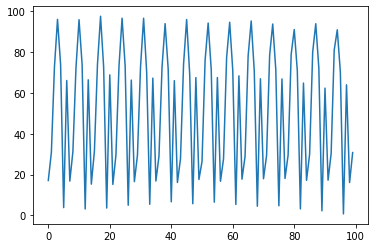

In [105]:
plt.plot(data[1])

In [108]:
from etna.models.nn.deepstate.deepstate import DeepStateModel
from etna.models.nn.deepstate.state_space_model import CompositeSSM, DaylySeasonalitySSM, WeeklySeasonalitySSM

In [109]:
horizon = 14
seq_lenght = 28
model = DeepStateModel(
    ssm = CompositeSSM(seasonal_ssms=[WeeklySeasonalitySSM()], nonseasonal_ssm=None),
    input_size=4,
    encoder_length=seq_lenght,
    decoder_length=horizon,
    train_batch_size=16,
    test_batch_size=16,
)

In [112]:
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform, StandardScalerTransform, SegmentEncoderTransform

In [113]:
pipeline = Pipeline(model=model, transforms=[SegmentEncoderTransform(), StandardScalerTransform(in_column="target")], horizon=horizon)